# CSCI218 Group Assignment: Decision Tree Implementation
---
Group: FT7

Group Members:
- Yuxiang Chen
- Marcela Fioneta
- Haoran Gao
- Zhihui Liu
- Yijia Wang
- Lorenzo Sayo Yanga

Code authored by Lorenzo Sayo Yanga

# **Installing and importing**

In [1]:
# Installing the ucimlrepo package
!pip install ucimlrepo

# Importing
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
  accuracy_score, precision_score,
  recall_score, f1_score, roc_auc_score, average_precision_score,
  ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.preprocessing import (
  LabelEncoder, StandardScaler, OrdinalEncoder
)
# For reproductibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Import Adult Dataset from UC Irvine Machine Learning Repository**

Adult dataset source: https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
def import_adult_dataset():
  # fetch dataset
  adult = fetch_ucirepo(name="Adult")

  # data (as pandas dataframes)
  X = adult.data.features
  y = adult.data.targets
  return X, y

# Print some basic info about the dataset
adult = fetch_ucirepo(name="Adult")

# metadata
print(adult.metadata)

# variable information
print(adult.variables)

# Use the defined function
X, y = import_adult_dataset()

# combine to a single df, so that it's easier to do cleaning
df_combined = pd.concat([X, y], axis=1)
df_combined.head()

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Analyse the dataset to see what needs to be done in terms of cleaning and preprocessing:

- Outliers at capital-gain (99999) and hours-per-week (99)
  - can potentially mean that they represent >99999 or >99 hours

- fnlwgt column
  - could be some kind of population weighting -- more for data analysis, may not be suitable for
- education column
  - can be relevant to determining salary, will encode in order
  - education-num is redundant and can be dropped

- There are '?' values in the dataset, they are treated as missing values (NA) and dropped

- Because we used fetch_ucirepo to import the dataset, the training and test data is combined.
  - Test data has '.' on values at the end of income. It will need to be fixed during preprocessing.

- native-country: There are ~40 countries, but United-States makes up 90% of the data.
  - More than half the countries have less than 100 people in them
  - One-hot encoding can result in dataset being too sparse (curse of dimensionality)

In [3]:
# Get numerical and categorical columns
numerical_cols = df_combined.select_dtypes(include=np.number).columns
categorical_cols = df_combined.select_dtypes(include='object').columns

print("--- Distributions for Numerical Columns ")
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(df_combined[col].describe())

print("\n--- Distributions for Categorical Columns ---")
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df_combined[col].value_counts())
    print("\nPercentage:")
    print(df_combined[col].value_counts(normalize=True) * 100)

--- Distributions for Numerical Columns 

Column: age
count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

Column: fnlwgt
count    4.884200e+04
mean     1.896641e+05
std      1.056040e+05
min      1.228500e+04
25%      1.175505e+05
50%      1.781445e+05
75%      2.376420e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64

Column: education-num
count    48842.000000
mean        10.078089
std          2.570973
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education-num, dtype: float64

Column: capital-gain
count    48842.000000
mean      1079.067626
std       7452.019058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

Column: capital-loss
count    48842.000000
mean       

Checking Dataset's missing values: there are '?' values on top of blank values. We treat '?' as missing values (NA) and drop them .

This removes ~7.41% of the dataset, which could potentially introduce bias.

In [4]:
# Check for any missing data in df
print("--- Before Cleaning ---")
print("No. of rows:", len(df_combined))
print("\nRows with missing values")
df_combined = df_combined.replace('?', np.nan)
print(df_combined.isna().sum())

--- Before Cleaning ---
No. of rows: 48842

Rows with missing values
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64


In [5]:
df_cleaned = df_combined.dropna()
# check after cleaning
print("--- After Cleaning ---")
print("No. of rows:", len(df_cleaned))
print(f"% of database lost after cleaning: \
  {(len(df_combined) - len(df_cleaned)) / len(df_combined) * 100:.2f} %")
print("\nRows with missing values")
print(df_cleaned.isna().sum())

--- After Cleaning ---
No. of rows: 45222
% of database lost after cleaning:   7.41 %

Rows with missing values
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


# Preprocessing data:
- Unify income values (to '<50k', '>=50')
- Scale numerical features
- Encoding of categorical features
  - Offer both one-hot (linear regressor) and label encoding (other encoding)

In [6]:

def preprocess_dataset(df, encode_onehot=True):
  # unify income
  df['income'] = df['income'].replace({
    '<=50K.': '<=50K',
     '>50K.': '>50K'
     })
  # encode the income column
  le = LabelEncoder()
  df['income'] = le.fit_transform(df['income'])

  # manually define numerical columns (to scale)
  num_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt']

  # define the rest of the
  cat_cols = [col for col in df.columns if col not in num_cols \
              and col != 'income']
  # encode sex column as it is binary
  cat_cols.remove('sex')
  oe = OrdinalEncoder()
  df['sex'] = oe.fit_transform(df[['sex']])

  if encode_onehot:
    # do one-hot encoding
    df = pd.get_dummies(df, columns=cat_cols)
  else:
    # remove education column from cat_cols to do ordinal encoding
    cat_cols.remove('education')
    edu_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors',
    'Masters', 'Prof-school', 'Doctorate'
    ]
    oe = OrdinalEncoder(categories=[edu_order])
    df['education'] = oe.fit_transform(df[['education']])

    # do ordinal encoding
    oe = OrdinalEncoder()
    for col in cat_cols:
        df[col] = oe.fit_transform(df[[col]])
  return df
df_cleaned = df_combined.drop("fnlwgt", axis=1)
df_cleaned = df_cleaned.drop("education-num", axis=1)

df_encode_onehot = preprocess_dataset(df_cleaned.copy(), encode_onehot=True)
df_encode_onehot.head()


,age,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,1.0,2174,0,40,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,1.0,0,0,13,0,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,1.0,0,0,40,0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,53,1.0,0,0,40,0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,28,0.0,0,0,40,0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [7]:
df_encode_noonehot = preprocess_dataset(df_cleaned.copy(), encode_onehot=False)
df_encode_noonehot.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6.0,12.0,4.0,0.0,1.0,4.0,1.0,2174,0,40,38.0,0
1,50,5.0,12.0,2.0,3.0,0.0,4.0,1.0,0,0,13,38.0,0
2,38,3.0,8.0,0.0,5.0,1.0,4.0,1.0,0,0,40,38.0,0
3,53,3.0,6.0,2.0,5.0,0.0,2.0,1.0,0,0,40,38.0,0
4,28,3.0,12.0,2.0,9.0,5.0,2.0,0.0,0,0,40,4.0,0


# Split dataset to 60/20/20 (training, validation, testing)

In [8]:
def split_dataset(X, Y):
  # splitting data
  # first split to 60%(train) and 40%(non-training)
  X_train, X_other, Y_train, Y_other = train_test_split(
    X, Y,
    test_size = 0.4,
    random_state = RANDOM_STATE,
    stratify = Y
  )

  # second split to get 20%(validation) and 20%(testing)
  X_val, X_test, Y_val, Y_test = train_test_split(
    X_other, Y_other,
    test_size = 0.5,
    random_state = RANDOM_STATE,
    stratify = Y_other # keeps class proportions similar
  )
  return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [9]:
# Combine everything above to generate a new (but same) set of X_train, val, test, etc. for testing on each model.

def generate_splitted_datasets(encode_onehot=True):
  X, Y = import_adult_dataset()

  # combine together so that we can clean it (dropping)
  df_combined = pd.concat([X, Y], axis=1)
  df_cleaned = df_combined.drop("fnlwgt", axis=1)
  df_cleaned = df_cleaned.drop("education-num", axis=1)
  df_cleaned = df_cleaned.replace('?', np.nan)
  df_cleaned = df_cleaned.dropna()

  # preprocessing
  df_pp = preprocess_dataset(df_cleaned, encode_onehot)

  X = df_pp.drop('income', axis=1)
  Y = df_pp['income']

  # then we can split it
  X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
  return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [10]:
# Printing out all the results
def evaluate_trained_model(model_name, model, X_test, Y_test):
  proba = model.predict_proba(X_test)[:, 1]
  pred = (proba >= 0.5).astype(int)
  return {
    "model": model_name,
    "accuracy": accuracy_score(Y_test, pred),
    "precision": precision_score(Y_test, pred, zero_division=0),
    "recall": recall_score(Y_test, pred, zero_division=0),
    "f1": f1_score(Y_test, pred, zero_division=0),
    "roc_auc": roc_auc_score(Y_test, proba)
  }, pred, proba

def print_results(model_name, model, X_test, Y_test):
  metrics, y_test_pred, y_test_proba = evaluate_trained_model(model_name, model, X_test, Y_test)
  metrics_df = pd.DataFrame([metrics])
  print("Results:")
  print(metrics_df)

  # Confusion Matrix
  print("\nConfusion Matrix:")
  plt.figure()
  ConfusionMatrixDisplay.from_predictions(
    Y_test,
    y_test_pred,
    display_labels=["<=50K", ">50K"],
    values_format="d"
  )
  plt.title("Confusion Matrix (Test) - " + model_name)
  plt.show()

  # ROC Curve
  print("\nROC Curve:")
  plt.figure()
  RocCurveDisplay.from_predictions(Y_test, y_test_proba)
  plt.title("ROC Curve (Test) - " + model_name)
  plt.show()

  return metrics


Using scikit-learn's default implementations of the models

`sklearn.tree.DecisionTreeClassifier` for Decision Tree

# **Code to set up and run Decision Tree**

In [11]:
X_train_dt, Y_train_dt, X_val_dt, Y_val_dt, X_test_dt, Y_test_dt = generate_splitted_datasets(encode_onehot=True)
dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
dt.fit(X_train_dt, Y_train_dt)
print("F1 Score (One-hot Encode):", f1_score(Y_test_dt, dt.predict(X_test_dt)))

X_train_dt, Y_train_dt, X_val_dt, Y_val_dt, X_test_dt, Y_test_dt = generate_splitted_datasets(encode_onehot=False)
dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
dt.fit(X_train_dt, Y_train_dt)
print("F1 Score (Ordinal Encode):", f1_score(Y_test_dt, dt.predict(X_test_dt)))


F1 Score (One-hot Encode): 0.4217406260749914
F1 Score (Ordinal Encode): 0.5755716675962075


Going forward, use ordinal-encoded dataset for the Decision Tree Model

In [12]:
# Fine tuning the model
X_train_dt, Y_train_dt, X_val_dt, Y_val_dt, X_test_dt, Y_test_dt = generate_splitted_datasets(encode_onehot=False)

# We'll be using max_depth
depths = [None, *range(1, 21)]
best_score = 0
best_depth = 0
for depth in depths:
  dt = DecisionTreeClassifier(
      max_depth=depth,
      random_state=RANDOM_STATE)
  dt.fit(X_train_dt, Y_train_dt)
  # use the validation set for this
  score = f1_score(Y_val_dt, dt.predict(X_val_dt))
  if depth is None:
    print(f"Depth: None | F1 Score: {score:.4f}")
  else:
    print(f"Depth: {depth:<5} | F1 Score: {score:.4f}")
  if score > best_score:
      best_score = score
      best_depth = depth
print(f"Best Depth Found: {best_depth}")
print(f"Best F1 Score: {best_score:.4f}")

Depth: None | F1 Score: 0.6165
Depth: 1     | F1 Score: 0.0000
Depth: 2     | F1 Score: 0.5346
Depth: 3     | F1 Score: 0.5838
Depth: 4     | F1 Score: 0.6127
Depth: 5     | F1 Score: 0.6362
Depth: 6     | F1 Score: 0.6416
Depth: 7     | F1 Score: 0.6409
Depth: 8     | F1 Score: 0.6434
Depth: 9     | F1 Score: 0.6450
Depth: 10    | F1 Score: 0.6745
Depth: 11    | F1 Score: 0.6567
Depth: 12    | F1 Score: 0.6696
Depth: 13    | F1 Score: 0.6549
Depth: 14    | F1 Score: 0.6561
Depth: 15    | F1 Score: 0.6633
Depth: 16    | F1 Score: 0.6559
Depth: 17    | F1 Score: 0.6503
Depth: 18    | F1 Score: 0.6473
Depth: 19    | F1 Score: 0.6368
Depth: 20    | F1 Score: 0.6349
Best Depth Found: 10
Best F1 Score: 0.6745


In [13]:
# Building the model
dt = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=RANDOM_STATE
)
dt.fit(X_train_dt, Y_train_dt)

DecisionTreeClassifier(max_depth=10, random_state=42)

Building the final model, and visual analysis of the results

Results:
           model  accuracy  precision    recall        f1   roc_auc
0  Decision Tree  0.850304   0.726994  0.634255  0.677465  0.900216

Confusion Matrix:


<Figure size 640x480 with 0 Axes>

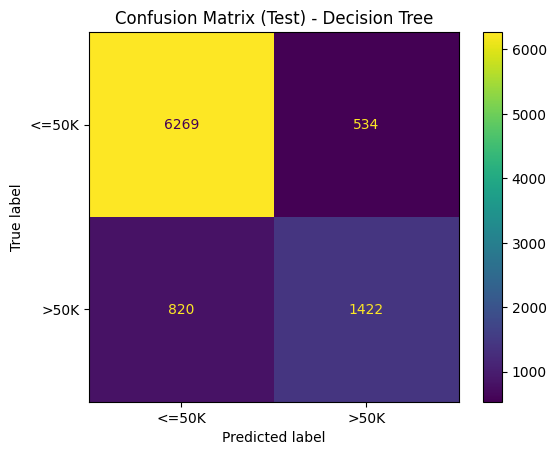


ROC Curve:


<Figure size 640x480 with 0 Axes>

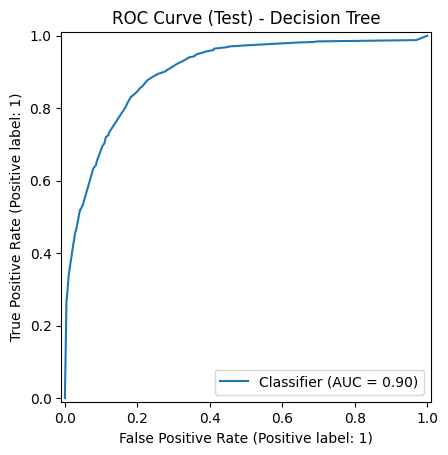

In [14]:
metrics_dt = print_results("Decision Tree", dt, X_test_dt, Y_test_dt)